In [1]:
from pathlib import Path
from typing import List

import numpy as np
import matplotlib.pyplot as plt

from kedro.extras.datasets.pickle import PickleDataSet
from kedro.config import ConfigLoader

import kornia.augmentation as K

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.utils import save_image

In [12]:
import os, sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src/'))

from src.tagseg.data.acdc_dataset import AcdcDataSet
from src.tagseg.data.dmd_dataset import DmdDataSet, DmdTimeDataSet
from src.tagseg.data.scd_dataset import ScdDataSet
from src.tagseg.pipelines.data_processing.nodes import preprocess_acdc
from src.tagseg.pipelines.data_splitting.nodes import split_data

In [3]:
conf_paths = ["../conf/base", "../conf/local"]
conf_loader = ConfigLoader(conf_paths)
conf_catalog = conf_loader.get("catalog*", "catalog*/**")

In [4]:
dmd = DmdDataSet(filepath='../' + conf_catalog['dmd_data']['filepath']).load()

In [13]:
acdc_file = PickleDataSet(filepath='../' + conf_catalog['acdc_data_cine_only_myo']['filepath'])
acdc_file_tag = PickleDataSet(filepath='../' + conf_catalog['acdc_data_tagged_only_myo']['filepath'])

In [14]:
acdc = acdc_file.load()
acdc_tag = acdc_file_tag.load()

In [7]:
def path(sl, group):
    return f'../../PyTorch-CycleGAN/datasets/taggedmr/{sl}/{group}/'

In [61]:
!rm -rf ../../PyTorch-CycleGAN/datasets/taggedmr/*
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/train
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/train/A
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/train/B
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/test
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/test/A
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/test/B

In [8]:
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/train/A/masks
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/train/B/masks
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/test/A/masks
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/test/B/masks

In [15]:
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/train/A/fake_tagged
!mkdir ../../PyTorch-CycleGAN/datasets/taggedmr/test/A/fake_tagged

In [11]:
train_val_split = 0.75

for group, dataset in [('A', acdc), ('B', dmd)]:
    
    n: int = len(dataset)
    n_train: int = round(n * train_val_split)
    split: List[int] = [n_train, n - n_train]

    train_set, val_set = random_split(
        dataset, split, generator=torch.Generator().manual_seed(42)
    )
    loader_train = DataLoader(train_set, batch_size=1, shuffle=True)
    loader_val = DataLoader(val_set, batch_size=1, shuffle=False)

    for sl, loader in [('train', loader_train), ('test', loader_val)]:
        
        save_path = path(sl, group)

        for idx, (image, mask) in enumerate(loader):

            img = image[0][0]
            msk = mask[0]

            scale = abs(img.min() - img.max())
            img = (img - img.min()) / scale

            # save_image(img, save_path + f'/img_{sl}_{group}_{idx}.png')
            np.savez(
                save_path + f'/masks/img_{sl}_{group}_{idx}.npz', 
                label=np.array(msk)
            )

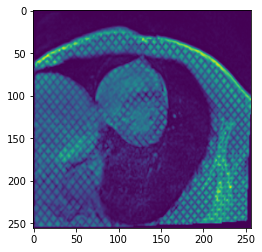

In [43]:
plt.imshow(dmd[0][0][0])

In [4]:
dataset = DmdTimeDataSet(filepath='../' + conf_catalog['dmd_time_data']['filepath']).load()

In [7]:
torch.empty((4, 512, 16, 16)).flatten(start_dim=1, end_dim=3).shape

torch.Size([4, 131072])

In [25]:
proba = .2

train_aug = K.AugmentationSequential(
    K.RandomHorizontalFlip(p=proba),
    K.RandomVerticalFlip(p=proba),
    K.RandomElasticTransform(p=proba),
    K.RandomGaussianNoise(p=proba),
    K.RandomSharpness(p=proba),
    K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.1), p=proba),
    data_keys=["input", "mask"],
)

In [31]:
a, b = train_aug(data.tensors[0][:8], torch.empty_like(data.tensors[0][:8]))
a.shape, b.shape

(torch.Size([8, 1, 256, 256]), torch.Size([8, 1, 256, 256]))

In [20]:
videos = dataset.tensors[1]
torch.cat(videos[:, 1:].unbind()).unsqueeze(1).shape

torch.Size([1008, 1, 256, 256])

In [21]:
data = DmdDataSet(filepath='../' + conf_catalog['dmd_data']['filepath']).load()

In [22]:
data.tensors[0].shape

torch.Size([42, 1, 256, 256])

In [ ]:
tagged = AcdcDataSet(
            filepath='../' + conf_catalog["raw_acdc_data"]["filepath"],
            tagged=True,
            only_myo=True,
        ).load()

In [ ]:
cine = acdc = AcdcDataSet(
            filepath='../' + conf_catalog["raw_acdc_data"]["filepath"],
            tagged=False,
            only_myo=True,
        ).load()

In [ ]:
len(cine)

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 8))

for i in range(13, 18):
    ax[0, i % 5].imshow(cine[4 * i + 21][0][0], cmap='gray');

    ax[0, i % 5].axis('off')
    
    ax[1, i % 5].imshow(tagged[4 * i + 21][0][0], cmap='gray')
    ax[1, i % 5].axis('off')

In [ ]:
fig, ax = plt.subplots(2, 10, figsize=(100, 20))

for col in range(10):

    image, label = dataset[col]

    ax[0, col].imshow(image[0], cmap='gray')
    ax[1, col].imshow(label)

In [ ]:
loaders = split_data(dataset, 0.75, 32)
loader_train, loader_val = loaders['loader_train'], loaders['loader_val']

In [ ]:
images, labels = next(iter(loader_train))
images.shape, labels.shape